# Goal

The goal of this analysis is to retrieve all similar pairs of car loans to determine if these similar loans received the same interest raste

In [1]:
import pandas as pd
df = pd.read_csv('cleaned.csv')

C:\Users\sweet\AppData\Local\Temp\ipykernel_4396\871723915.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned.csv')


In [2]:
df.head()

,assetNumber,originalLoanAmount,originalLoanTerm,Scheduled Payment Amount,interestRate,reportingPeriodEndingDate,originalFirstPaymentDate,underwritingIndicator,gracePeriodNumber,subvented,...,nextReportingPeriodPaymentAmountDue,currentDelinquencyStatus,reportingPeriodBeginningDate,originatorName,originationDate,loanMaturityDate,vehicleManufacturerName,vehicleModelName,reportingPeriodBeginningLoanBalanceAmount,obligorGeographicLocation
0,537581964,40873.54,72,601.109763,0.0190,2/28/2022,5/1/2021,0.0,0,1,...,1202.22,1.0,2/1/2022,TMCC,05/2021,04/2027,LEXUS,LX IS 300,36573.22,CA
1,362660414,34991.78,72,561.918571,0.0490,2/28/2022,3/1/2021,0.0,0,1,...,864.96,1.0,2/1/2022,TMCC,03/2021,02/2027,TOYOTA,SIENNA,29932.87,CT
2,234565769,25777.35,72,379.096519,0.0190,2/28/2022,8/1/2020,0.0,0,1;2,...,758.18,1.0,2/1/2022,TMCC,08/2020,07/2026,TOYOTA,CAMRY,19605.36,CA
3,224112672,21659.20,72,380.708480,0.0809,2/28/2022,8/1/2020,0.0,0,2,...,761.40,1.0,2/1/2022,TMCC,08/2020,07/2026,TOYOTA,CAMRY,17164.56,CA
4,530166042,36085.40,72,666.693978,0.0990,2/28/2022,5/1/2021,0.0,0,2,...,666.69,0.0,2/1/2022,TMCC,05/2021,05/2027,TOYOTA,VENZA,33178.82,CA


In [3]:
df.shape

(5402476, 28)

In [4]:
df.originatorName.unique()

array(['TMCC', 'Fifth Third Bank National Association',
       'BMW Bank of North America', 'Exeter Finance',
       'WORLD OMNI FINANCIAL CORP', 'Ally Bank', 'Ford Credit', 'NMAC',
       'USAAFSB', 'VW Credit', 'AHFC', 'MBFS USA LLC', 'SC',
       'Carvana, LLC', 'Mechanics Bank'], dtype=object)

In [5]:
import itertools

Criteria:  
Same Model Year  
Same Model  
Same Loan Term  
Same Origination Month  
Vehicle Value: +- 10% of value A  
Credit Score: +- 7 points of value A  
PTI: +- 10% of value A  
Loan Amount: +- 5%   

In [6]:
# Retrieves combinations
def getCombos(dat, vehicle_years, vehicle_models, loan_terms, orig_dates):
    
    output = []
    
    num_rows = dat[(dat['vehicleModelYear'].isin(vehicle_years)) & (dat['vehicleModelName'].isin(vehicle_models)) & 
                      (dat['originalLoanTerm'].isin(loan_terms)) & (dat['originationDate'].isin(orig_dates))].shape[0]
    
    # For every combination of year, model, term, and origination date
    for v_year, v_model, l_term, orig_date in itertools.product(vehicle_years, vehicle_models, loan_terms, orig_dates):
        # filter dataset to these years
        result = dat[(dat['vehicleModelYear']==v_year) & (dat['vehicleModelName']==v_model) & 
                      (dat['originalLoanTerm']==l_term) & (dat['originationDate']==orig_date)]
        # If there is at least 1 combination,
        if result.shape[0] < 2:
            continue
        # For every combination of rows in resulting set
        for combo in itertools.combinations(result.values, 2):
            # determine if within 7 obligorCreditScore points
            if not abs(combo[0][13] - combo[1][13]) < 8:
                continue
            # determine if within 5% of originalLoanAmount
            if not abs(combo[0][1] - combo[1][1]) < (0.05 * combo[0][1]):
                continue
            # determine if within 10% of paymentToIncomePercentage
            if not abs(combo[0][17] - combo[1][17]) < (0.1 * combo[0][17]):
                continue
            # determine if within 10% of vehicleValueAmount
            if not abs(combo[0][12] - combo[1][12]) < (0.1 * combo[0][12]):
                continue
            # Append combination to list, using itertools.chain to flatten combo to single element
            output.append(list(itertools.chain(*combo)))
    # generate column names for resulting dataframe
    A_names = [col + ' A' for col in list(df.columns)]
    B_names = [col + ' B' for col in list(df.columns)]
    # convert list to dataframe
    output = pd.DataFrame(output, columns=A_names+B_names)
    # record rows of source dataset for context
    output['total_rows'] = num_rows
    # record absolute difference in interest rate
    output['interest_diff'] = abs(output['interestRate A'] - output['interestRate B'])
    return output

I will be starting with Volkswagen Credit, a captive originator. Due to the size of the data and the vastness of the combinations needed to assess, I will be filtering this data down using analysis done in tableau.

In [7]:
exeter = df[df['originatorName'] == 'Exeter Finance']

In [8]:
import matplotlib.pyplot as plt

(array([7.60000e+01, 5.16000e+02, 4.97600e+03, 1.85170e+04, 4.82700e+04,
        8.54470e+04, 1.16896e+05, 8.94590e+04, 2.08160e+04, 7.12000e+02]),
 array([2004. , 2005.9, 2007.8, 2009.7, 2011.6, 2013.5, 2015.4, 2017.3,
        2019.2, 2021.1, 2023. ]),
 <BarContainer object of 10 artists>)

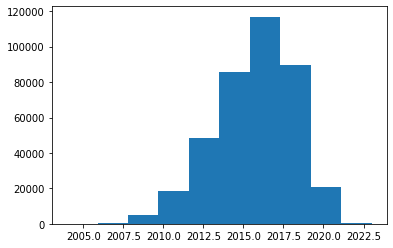

In [9]:
plt.hist(exeter['vehicleModelYear'])

Using the quantity of loans distributed across vehicle years, I chose to only concentrate on years 2010 and to 2020.

In [10]:
import itertools, numpy as np
vehicle_years = [*range(2010, 2021)]
vehicle_years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [11]:
exeter.columns

Index(['assetNumber', 'originalLoanAmount', 'originalLoanTerm',
       'Scheduled Payment Amount', 'interestRate', 'reportingPeriodEndingDate',
       'originalFirstPaymentDate', 'underwritingIndicator',
       'gracePeriodNumber', 'subvented', 'vehicleNewUsedCode',
       'vehicleModelYear', 'vehicleValueAmount', 'obligorCreditScore',
       'obligorIncomeVerificationLevelCode',
       'obligorEmploymentVerificationCode', 'coObligorIndicator',
       'paymentToIncomePercentage', 'nextReportingPeriodPaymentAmountDue',
       'currentDelinquencyStatus', 'reportingPeriodBeginningDate',
       'originatorName', 'originationDate', 'loanMaturityDate',
       'vehicleManufacturerName', 'vehicleModelName',
       'reportingPeriodBeginningLoanBalanceAmount',
       'obligorGeographicLocation'],
      dtype='object')

In [12]:
exeter.groupby(by='vehicleModelName').sum().sort_values('originalLoanAmount', ascending=False)['originalLoanAmount'][0:10]

vehicleModelName
SILVERADO 1500    2.167387e+08
ALTIMA            2.141394e+08
F150              2.090205e+08
1500              1.874098e+08
ACCORD            1.733467e+08
MALIBU            1.695956e+08
EQUINOX           1.662198e+08
CAMRY             1.573057e+08
FUSION            1.562118e+08
ROGUE             1.560408e+08
Name: originalLoanAmount, dtype: float64

I chose the top 10 model names by loan amount

In [13]:
vehicle_models = exeter.groupby(by='vehicleModelName').sum().sort_values('originalLoanAmount', ascending=False)[0:10] 
vehicle_models = list(vehicle_models.index)
vehicle_models

['SILVERADO 1500',
 'ALTIMA',
 'F150',
 '1500',
 'ACCORD',
 'MALIBU',
 'EQUINOX',
 'CAMRY',
 'FUSION',
 'ROGUE']

In [14]:
loan_terms = exeter.groupby(by='originalLoanTerm').count().sort_values('originalLoanTerm', ascending=False)[0:10] 
loan_terms = list(loan_terms.index)
loan_terms

[80, 79, 78, 77, 76, 75, 74, 73, 72, 71]

Likewise, I only focused on the latest full year data was available for all originators

In [15]:
orig_dates = ['01/2020', '02/2020', '03/2020', '04/2020', '05/2020', '06/2020', '07/2020', '08/2020',
              '09/2020', '10/2020', '11/2020', '12/2020']
orig_dates

['01/2020',
 '02/2020',
 '03/2020',
 '04/2020',
 '05/2020',
 '06/2020',
 '07/2020',
 '08/2020',
 '09/2020',
 '10/2020',
 '11/2020',
 '12/2020']

In [16]:
exeter_combos = getCombos(exeter, vehicle_years, vehicle_models, loan_terms, orig_dates)
exeter_combos

,assetNumber A,originalLoanAmount A,originalLoanTerm A,Scheduled Payment Amount A,interestRate A,reportingPeriodEndingDate A,originalFirstPaymentDate A,underwritingIndicator A,gracePeriodNumber A,subvented A,...,reportingPeriodBeginningDate B,originatorName B,originationDate B,loanMaturityDate B,vehicleManufacturerName B,vehicleModelName B,reportingPeriodBeginningLoanBalanceAmount B,obligorGeographicLocation B,total_rows,interest_diff
0,210471729924254301,11084.00,74,315.953223,0.2800,2/28/2022,9/1/2020,1.0,2,0,...,2/1/2022,Exeter Finance,07/2020,10/2026,TOYOTA,CAMRY,10559.81,WI,20582,0.0533
1,210204229922854301,13639.77,74,319.431514,0.1966,2/28/2022,8/1/2020,1.0,2,0,...,2/1/2022,Exeter Finance,06/2020,11/2026,TOYOTA,CAMRY,13092.22,NC,20582,0.0834
2,210861229930154301,14943.59,74,387.456482,0.2387,2/28/2022,1/1/2021,1.0,2,0,...,2/1/2022,Exeter Finance,11/2020,12/2026,NISSAN,ALTIMA,0.00,VA,20582,0.0245
3,210566729928954301,25361.69,74,698.878893,0.2650,2/28/2022,12/1/2020,1.0,2,0,...,2/1/2022,Exeter Finance,10/2020,11/2026,FORD,F150,23656.27,OH,20582,0.0267
4,210045029922154301,23021.33,73,603.464943,0.2408,2/28/2022,7/1/2020,1.0,1,0,...,2/1/2022,Exeter Finance,06/2020,08/2026,FORD,F150,20786.61,MO,20582,0.0067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,210972629928254301,21035.99,73,482.826294,0.1856,2/28/2022,11/1/2020,1.0,1,0,...,2/1/2022,Exeter Finance,10/2020,12/2026,NISSAN,ALTIMA,18686.96,MD,20582,0.0412
355,210754029930854301,18837.08,73,364.328184,0.1195,2/28/2022,1/1/2021,1.0,1,0,...,2/1/2022,Exeter Finance,12/2020,02/2027,NISSAN,ALTIMA,18051.81,GA,20582,0.0288
356,210953729930754301,23035.00,73,521.366902,0.1800,2/28/2022,1/1/2021,1.0,1,0,...,2/1/2022,Exeter Finance,12/2020,12/2026,NISSAN,ALTIMA,19802.32,LA,20582,0.0000
357,210221329931254301,20617.00,74,519.429485,0.2266,2/28/2022,2/1/2021,1.0,2,0,...,2/1/2022,Exeter Finance,12/2020,02/2027,CHEVROLET,MALIBU,20087.37,MI,20582,0.0167


In [17]:
max(exeter_combos['interest_diff'])

0.14100000000000001

In [18]:
np.mean(exeter_combos['interest_diff'])

0.03407381615598886

In [19]:
exeter_combos.to_csv('exeter.csv')